In [1]:
import numpy as np
import pandas as pd
import torch
import json
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
import scipy

import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from sklearn.cluster import KMeans

import seaborn as sns

from torcheval.metrics.functional import r2_score

# The main idea is to generate pseudo-labels (aka guessed labels) to computate both Labeled abd Unlabeled losses

### Weights that describes distribution of data in cells (Gaussian like)

In [2]:
def get_weigths(dataset):
    weights = []
    for batches in dataset:
        batch_weights = []
        for batch in batches:
            target_weights = []
            for y in batch:
                # where it belongs
                for j in range(len(bin_edges)-1):
                    if y >= bin_edges[j] and y <= bin_edges[j+1]:
                        target_weights.append(
                            error_weights[j]
                        )
            batch_weights.append(target_weights)
        weights.append(batch_weights)
    weights = np.array(weights)
    weights = torch.from_numpy(weights)
    # weights = weights.to(device)
    return weights
# print(yhat_loss.shape)

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

## Making training-testing tensor datasets under CV split

In [4]:
with open("core_parts.json", "r") as f:
    core_parts = json.load(f)

In [266]:
cores_l = pd.read_excel("input.xlsx", sheet_name="no_burnup")
cores_u = pd.read_excel("burnup_only.xlsx", index_col=0)

In [267]:
fuel_types = cores_l.loc[0, core_parts["fuel_type"]["ALL_CELLS"]].to_numpy()

In [268]:
cores_l.loc[:, core_parts["left"]["ALL_CELLS"]] = fuel_types - cores_l.loc[:, core_parts["burnup"]["ALL_CELLS"]].to_numpy()
cores_u.loc[:, core_parts["left"]["ALL_CELLS"]] = fuel_types - cores_u.loc[:, core_parts["burnup"]["ALL_CELLS"]].to_numpy()

In [269]:
cores_u.loc[:, core_parts["coef"]["ALL_CELLS"]] = None

### Shuffle dataframes before tensorizing

In [270]:
cores_l = cores_l.sample(frac=1)
cores_u = cores_u.sample(frac=1)

In [271]:
cores_l_Xtofit = cores_l.loc[:, 
    [
        *core_parts["burnup"]["ALL_CELLS"],
        # *core_parts["left"]["ALL_CELLS"]
    ]
]
cores_l_ytofit = cores_l.loc[:, 
    [
        *core_parts["coef"]["ALL_CELLS"]
    ]
]

In [272]:
mmsX = MinMaxScaler(feature_range=(0,1))
mmsX.fit(cores_l_Xtofit)

mmsy = MinMaxScaler(feature_range=(0,1))
mmsy.fit(cores_l_ytofit)

MinMaxScaler()

In [289]:
# cores_u = cores_l.iloc[80:160, :]
cores_l = cores_l.iloc[:80, :]
# cores_u.loc[:, core_parts["coef"]["ALL_CELLS"]] = None

<Axes: xlabel='7-6_b', ylabel='7-6_s'>

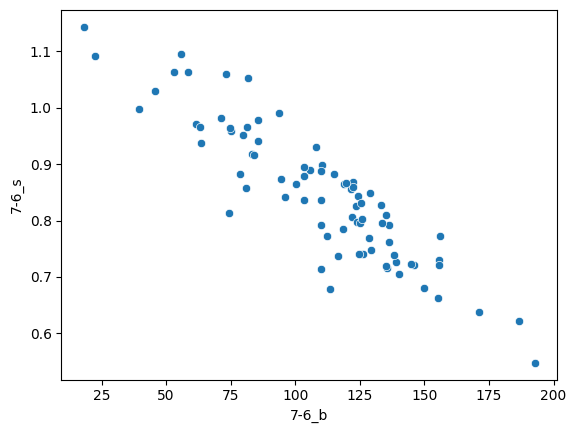

In [290]:
sns.scatterplot(x=cores_l.loc[:, core_parts["burnup"]["ALL_CELLS"][0]], y=cores_l.loc[:, core_parts["coef"]["ALL_CELLS"][0]])

In [291]:
cores_u.shape, cores_l.shape

((12000, 60), (80, 82))

### Dataset formation

In [292]:
Xl = cores_l.loc[:, 
    [
        *core_parts["burnup"]["ALL_CELLS"],
        # *core_parts["left"]["ALL_CELLS"]
    ]
]
yl = cores_l.loc[:, core_parts["coef"]["ALL_CELLS"]]

In [293]:
Xu = cores_u.loc[:, 
    [
        *core_parts["burnup"]["ALL_CELLS"],
        # *core_parts["left"]["ALL_CELLS"]
    ]
]
yu = cores_u.loc[:, core_parts["coef"]["ALL_CELLS"]]

In [294]:
Xl = mmsX.transform(Xl)
Xu = mmsX.transform(Xu)

yl = mmsy.transform(yl)


### CV split

In [320]:
ns = 5
kf = KFold(n_splits=ns)
train_size = int(len(Xl) * (ns-1) / ns)
test_size = len(Xl) - train_size
splits_ind = list(kf.split(Xl))
train_size, test_size

(64, 16)

### Started with making batches of tensors

In [353]:

# batch size of labeled data
lbatch = 4
# test set tensor
tbatch = 4

# unlabeled batch size and U to L ratio
cores_l_taken = train_size
cr = 32 * cores_l_taken
print(cr)
RUL = f"{cr}_{cores_l_taken}"

Xu_cr = Xu[:cr]
yu_cr = yu[:cr]

cv_datasets = []
for (train, test) in splits_ind[:ns]:
    Xyl_train = np.concatenate(
        ( Xl[train], yl[train] ),
        axis=1
    )
    Xylb_train = np.asarray(np.split(Xyl_train, len(Xyl_train)/lbatch))
    Xylb_train = np.asarray(Xylb_train).astype("float32")

    # tensor
    Xylb_train_tensor = torch.from_numpy(Xylb_train)

    Xyu_train = np.concatenate(
        (Xu_cr, yu_cr),
        axis=1
    )
    
    Xyub_train = np.asarray(np.split(Xyu_train, len(Xyl_train)/lbatch))
    Xyub_train = np.asarray(Xyub_train).astype("float32")
    
    Xyub_train_tensor = torch.from_numpy(Xyub_train)
    
    Xyl_test = np.concatenate(
        ( Xl[test], yl[test] ),
        axis=1
    )
    
    Xylb_test = np.asarray(np.split(Xyl_test, len(Xyl_test)/tbatch))
    Xylb_test = np.asarray(Xylb_test).astype("float32")
    # tensor
    Xylb_test_tensor = torch.from_numpy(Xylb_test)
    print(
        "train_set: ", Xylb_train_tensor.shape, 
        "test_set: ", Xylb_test_tensor.shape,
        "unlabeled_set: ", Xyub_train_tensor.shape
    )

    # do concat of L and U tensors
    Xy_train_tensor_cat = torch.cat(
        (Xylb_train_tensor, Xyub_train_tensor),
        dim=1
    )
    # shuffle batches
    Xy_train_tensor_cat = Xy_train_tensor_cat[
        torch.randperm(
            Xy_train_tensor_cat.shape[0] #index of batches
        )
    ]
    print(Xy_train_tensor_cat.shape)
    # train test tensors split
    inputs = 20
    X_train_tensor = Xy_train_tensor_cat[:, :, :inputs]
    X_test_tensor = Xylb_test_tensor[: , :, :inputs]
    
    y_train_tensor = Xy_train_tensor_cat[:, :, inputs:]
    y_test_tensor = Xylb_test_tensor[: , :, inputs:]

    # tensor dataset
    xy_train = TensorDataset(
        X_train_tensor,
        y_train_tensor
    )
    
    xy_test =  TensorDataset(
        X_test_tensor,
        y_test_tensor,
    )
    # to unpack and iterate over
    cv_datasets.append(
        (xy_train, xy_test)
    )
    

2048
train_set:  torch.Size([16, 4, 40]) test_set:  torch.Size([4, 4, 40]) unlabeled_set:  torch.Size([16, 128, 40])
torch.Size([16, 132, 40])
train_set:  torch.Size([16, 4, 40]) test_set:  torch.Size([4, 4, 40]) unlabeled_set:  torch.Size([16, 128, 40])
torch.Size([16, 132, 40])
train_set:  torch.Size([16, 4, 40]) test_set:  torch.Size([4, 4, 40]) unlabeled_set:  torch.Size([16, 128, 40])
torch.Size([16, 132, 40])
train_set:  torch.Size([16, 4, 40]) test_set:  torch.Size([4, 4, 40]) unlabeled_set:  torch.Size([16, 128, 40])
torch.Size([16, 132, 40])
train_set:  torch.Size([16, 4, 40]) test_set:  torch.Size([4, 4, 40]) unlabeled_set:  torch.Size([16, 128, 40])
torch.Size([16, 132, 40])


## Model

In [354]:
class Model(nn.Module):
    def __init__(
        self
    ):
        super().__init__()

        # self.encoder = nn.Sequential(
        #     nn.Linear(20, 10),
        #     nn.ReLU(),
        #     nn.Linear(10, 5),
        #     nn.Sigmoid()
        # )
        
        # FNN
        self.predictor = nn.Sequential(
            nn.Linear(20, 5),
            # nn.Dropout(0.1),
            nn.ReLU(),
            # nn.Linear(5, 1),
            # nn.Sigmoid()
        )
        self.yhat = nn.Linear(5,1)
        self.eps = nn.Linear(5,1)
    
    def forward(
        self,
        x        
    ):
        
        x = self.predictor(x)

        labels = F.sigmoid(self.yhat(x))
        eps = F.relu(self.eps(x))
        
        return labels

def supervised_loss(
    target,
    pred,
    batch_size
):
    
    yhat_loss = F.l1_loss(pred, target, reduction='sum') / batch_size
    
    return yhat_loss


def unsupervised_loss(
    target_mean,
    pred, 
    batch_size
):
    
    yhat_loss = F.l1_loss(pred, target_mean, reduction='sum') / batch_size
    # print(pred[0], target_mean[0])
    # yhat_loss = torch.sqrt(yhat_loss)
    return yhat_loss 

In [355]:
def test(
    model,
    dataset,
    L,
    epoch_num
):

        loss_epoch = 0
        mseloss_epoch = 0
        r2_epoch = 0
        with torch.no_grad():
            for nbatch, (X,y) in enumerate(dataset):
                # so it is shape of [32, 1]
                y = y[:, 0:1]
                
                
                y = y.to(device)
                y_deep = torch.clone(y)

                X = X.to(device)
                
                labels = model(X)

                # print(
                #     "Test: ",
                #     labels[0],
                #     y[0]
                # )

                loss = F.l1_loss(labels, y)
                loss_epoch += loss.item()

                mseloss = F.mse_loss(labels, y)
                mseloss_epoch += mseloss.item()
                
                r2 = r2_score(labels, y, multioutput="raw_values")
                r2_mean = r2.mean()
                r2_epoch += r2_mean.item()
            
                
            
            loss_epoch = loss_epoch / len(dataset)
            mseloss_epoch = mseloss_epoch / len(dataset) * 100
            r2_epoch = r2_epoch / len(dataset)
            
            print(r2_epoch)

            return loss_epoch, mseloss_epoch, r2_epoch
            



In [357]:
# yaug = 0.1

def get_noise(loc, scale, size, coef=0.1):
    
    tril = torch.diag_embed(scale)
    mvn = torch.distributions.MultivariateNormal(
        loc,
        scale_tril=tril
    )
    samples = mvn.sample(torch.Size([size]))
    res = ( samples - samples.mean(dim=0) )*coef

    return res

def get_row_noise(batch, coef):
    # columns_shape = batch.shape[-1]
    columns_mean = batch.mean(dim=1)

    noise1 = torch.rand(*batch.shape)*coef
    noise2 = torch.rand(*batch.shape)*coef

    noise = noise1 - noise2
    # print(batch[0], noise[0] + batch[0])
    # print(batch[0].mean(), (noise[0] + batch[0]).mean())
    return noise
    
    

def train(
    model,
    dataset,
    L,
    u,
    noise_level,
    optimizer,
    epoch_num,
):
        loss_epoch  = 0
        
        yl_epoch_loss = 0
        yu_epoch_loss = 0


        for nbatch, (X,y) in enumerate(dataset):
            # so it is shape of [32, 1]
            y = y[:, 0:1]
            
            y = y.to(device)
            # left only cell 7-6
            
            
            y_deep = torch.clone(y)

            Xl = X[:lbatch]
            Xu = X[lbatch:]
            # print(Xl.shape, Xu.shape)
            yl = y[:lbatch]
            yu = y[lbatch:]

            Xaug_up = torch.tensor([])
            Xaug_um = torch.tensor([])
            Xaug_lp = torch.tensor([])
            Xaug_lm = torch.tensor([])
            
            for _ in range(L):
                # aug l part
                
                noise_l = get_row_noise(Xl, noise_level)
                
                Xaug_lp = torch.cat(
                    (
                        Xaug_lp,
                        Xl + noise_l    
                    ),
                    dim=0
                )
                Xaug_lm = torch.cat(
                    (
                        Xaug_lm,
                        Xl - noise_l    
                    ),
                    dim=0
                )
                # print(nbatch, Xl[0])
                
                # aug u part
                noise_u = get_row_noise(Xu, noise_level)
                
                # add
                Xaug_up = torch.cat(
                    (
                        Xaug_up,
                        Xu + noise_u    
                    ),
                    dim=0
                )
                # print(Xu[0], noise_u[0], Xaug_up[0])
                # sub
                Xaug_um = torch.cat(
                    (
                        Xaug_um,
                        Xu - noise_u    
                    ),
                    dim=0
                )
            
            # simple aug of Xl
            # noise_l = get_row_noise(Xl, noise_level)
            # Xaug_lp = Xl + noise_l
            # Xaug_lm = Xl - noise_l

            # noise_u = get_row_noise(Xu, noise_level)
            # Xaug_up = Xu + noise_u
            # Xaug_um = Xu - noise_u
            
            # Zero the gradients
            optimizer.zero_grad()

            # Xaug_l = Xaug_l.to(device)
            
            Xl = Xl.to(device)
            Xu = Xu.to(device)
            
            Xaug_lp = Xaug_lp.to(device)
            Xaug_lm = Xaug_lm.to(device)
            
            Xaug_up = Xaug_up.to(device)
            Xaug_um = Xaug_um.to(device)
            

            labels_l = model(Xl)
            # loss_u = torch.tensor(0)

            if u != 0:
                labels_lp = model(Xaug_lp)
                labels_lm = model(Xaug_lm)
                labels_lpm = (labels_lp + labels_lm) / 2
    
                labels_lpm_chunks = torch.reshape(
                    labels_lpm, 
                    (L, int(labels_lpm.shape[0]/L), labels_lpm.shape[-1])
                )
                labels_lpm = labels_lpm_chunks.mean(dim=0)
                labels_l = labels_lpm # + torch.abs(labels_lpm - labels_l)
                # print("Labeled")
                # print(labels_lpm[0], labels_l[0])
            
                labels_up = model(Xaug_up)
                labels_um = model(Xaug_um)
                
                # labels_upm = (labels_up + labels_um) / 2
    
                # labels_upm_chunks = torch.reshape(
                #     labels_upm, 
                #     (L, int(labels_upm.shape[0]/L), labels_upm.shape[-1])
                # )
                # labels_upm = labels_upm_chunks.mean(dim=0)
                
                # # lets say it is mean for u data
                # labels_u = model(Xu)
                # # print("Ulabeled")
                # # print(labels_upm[0], labels_u[0])
                # loss_u = unsupervised_loss(
                #     labels_u,
                #     labels_upm,
                #     labels_u.shape[0]
                # )
                loss_u = unsupervised_loss(
                    labels_up,
                    labels_um,
                    labels_up.shape[0]
                )
                yu_epoch_loss += loss_u.item()

                #supervised
                loss_l = supervised_loss(
                    yl,
                    labels_l,
                    Xl.shape[0]
                )
                
                yl_epoch_loss += loss_l.item()
            
                # l + u only
                loss = loss_l - u*loss_u
            
            else:
                #supervised
                loss_l = supervised_loss(
                    yl,
                    labels_l,
                    Xl.shape[0]
                )
                
                yl_epoch_loss += loss_l.item()
                # l + u only
                loss = loss_l
            
            # new u loss as a difference with negative values
            # loss_u = (labels_u - labels_upm).sum() / labels_u.shape[0]
            # remove negative values
            # loss_u = torch.abs(loss_u)
            
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
            
        
        
    
        loss_epoch = loss_epoch / len(dataset)
        yl_epoch_loss = yl_epoch_loss / len(dataset)
        yu_epoch_loss = yu_epoch_loss / len(dataset)
    
        print(
            yu_epoch_loss,
            yl_epoch_loss,
            
        )

        return loss_epoch, yl_epoch_loss, yu_epoch_loss


        



In [358]:
U = [0.01, 0.05, 0.1, 0.5, 1, 5]
U = [0]
# Ls = [1,2,3,4,5,6,7,8,9,10]
Ls = [1, 8, 16]
# Ls = [1]

noise=0.1
for u in U:
    for L in Ls:
        writer = SummaryWriter(f'ssl/residuals_negUloss_noise{noise}_1label_Xaug_l_bs_{lbatch}_bydiff_up_um/RUL_{RUL}/L{L}/{u}_ucoef')
        
        train_loss_cv, train_yl_loss_cv, train_yu_loss_cv = [], [], []
        test_loss_cv, test_mseloss_cv, test_r2_cv = [], [], []
        
        # for (xy_train, xy_test) in cv_datasets:
        # instead of cv we do run same model multiple times to average results
        xy_train, xy_test = cv_datasets[0]
        for _ in range(5):
            model = Model().to(device)
            adam = torch.optim.Adam(model.parameters())
            epoch = 600

            train_loss_epoches, train_yl_loss_epoches, train_yu_loss_epoches = [], [], []
            test_loss_epoches, test_mseloss_epoches, test_r2_epoches = [], [], []
            for e in range(epoch):
                train_loss_epoch, train_yl_epoch_loss, train_yu_epoch_loss = train(
                    model,
                    xy_train,
                    L,
                    u,
                    noise,
                    adam,
                    e
                )
                train_loss_epoches.append(train_loss_epoch)
                train_yl_loss_epoches.append(train_yl_epoch_loss)
                train_yu_loss_epoches.append(train_yu_epoch_loss)
                 
                test_loss_epoch, test_mseloss_epoch, test_r2_epoch = test(
                    model,
                    xy_test,
                    L,
                    e
                )
                test_loss_epoches.append(test_loss_epoch)
                test_r2_epoches.append(test_r2_epoch)
                test_mseloss_epoches.append(test_mseloss_epoch)
            
            train_loss_cv.append(train_loss_epoches)
            train_yl_loss_cv.append(train_yl_loss_epoches)
            train_yu_loss_cv.append(train_yu_loss_epoches)
            
            test_loss_cv.append(test_loss_epoches)
            test_mseloss_cv.append(test_mseloss_epoches)
            test_r2_cv.append(test_r2_epoches)
        
        # averaging results over cv
        train_loss_cv = np.asarray(train_loss_cv).mean(axis=0)
        train_yl_loss_cv = np.asarray(train_yl_loss_cv).mean(axis=0)
        train_yu_loss_cv = np.asarray(train_yu_loss_cv).mean(axis=0)
        
        test_loss_cv = np.asarray(test_loss_cv).mean(axis=0)
        test_mseloss_cv = np.asarray(test_mseloss_cv).mean(axis=0)
        test_r2_cv = np.asarray(test_r2_cv).mean(axis=0)
        
        # adding to writer
        for e in range(len(test_loss_cv)):
            # print(e)
            writer.add_scalar('Train/epoch_loss', train_loss_cv[e], global_step=e)
            writer.add_scalar('Train/yl_Loss', train_yl_loss_cv[e], global_step=e)
            writer.add_scalar('Train/yu_Loss', train_yu_loss_cv[e], global_step=e)
            
            
            writer.add_scalar('Test/y_loss', test_loss_cv[e], global_step=e)
            writer.add_scalar('Test/ymse_loss', test_mseloss_cv[e], global_step=e)
            writer.add_scalar('Test/r2_mean', test_r2_cv[e], global_step=e)
        # if u == 0:
        #     break

0.0 0.12840617168694735
-0.6855439841747284
0.0 0.12612668424844742
-0.6675353646278381
0.0 0.12505625281482935
-0.6498476266860962
0.0 0.12433100491762161
-0.6383490264415741
0.0 0.12380920816212893
-0.6337417364120483
0.0 0.12360493838787079
-0.6288850009441376
0.0 0.12345100659877062
-0.6244280338287354
0.0 0.12333620432764292
-0.6220292150974274
0.0 0.12319258693605661
-0.6201510429382324
0.0 0.12303648889064789
-0.6179910898208618
0.0 0.12287100777029991
-0.6152834892272949
0.0 0.12268976587802172
-0.611720085144043
0.0 0.1224954891949892
-0.6076095700263977
0.0 0.12227979209274054
-0.6029810309410095
0.0 0.12203850038349628
-0.5976600497961044
0.0 0.12178672663867474
-0.5925889015197754
0.0 0.12150427885353565
-0.5871158689260483
0.0 0.12118939962238073
-0.5807587951421738
0.0 0.12084677070379257
-0.5736899077892303
0.0 0.12047207076102495
-0.5657964497804642
0.0 0.12007887661457062
-0.5578626394271851
0.0 0.11964999046176672
-0.5493669211864471
0.0 0.11917715147137642
-0.5398077

In [210]:
  # # aug supervised
            # # chunks to average res
            # labels_augl_chunks = torch.reshape(
            #     labels_augl, 
            #     (L, int(labels_augl.shape[0]/L), labels_augl.shape[-1])
            
            # )
            # labels_augl_mean = labels_augl_chunks.mean(dim=0)
            # # calc upon true yl
            # loss_augl_true = unsupervised_loss(
            #     yl,
            #     labels_augl_chunks,
            #     yl.shape[0]
            # )
            # yaugl_true_loss = loss_augl_true.item()

            # # calc upon aug mean
            # loss_augl = unsupervised_loss(
            #     labels_augl_mean,
            #     labels_augl_chunks,
            #     labels_augl_mean.shape[0]
            # )
            # yaugl_loss = loss_augl.item()

            # # perfect case when it's around 0
            # loss_yaugl = torch.abs(
            #     (torch.abs(loss_augl_true) - torch.abs(loss_augl))
            # )

In [168]:
# yaug = 0.1

def get_noise(loc, scale, size, coef=0.1):
    
    tril = torch.diag_embed(scale)
    mvn = torch.distributions.MultivariateNormal(
        loc,
        scale_tril=tril
    )
    samples = mvn.sample(torch.Size([size]))
    res = ( samples - samples.mean(dim=0) )*coef

    return res

def get_row_noise(batch, coef):
    # columns_shape = batch.shape[-1]
    columns_mean = batch.mean(dim=1)

    noise1 = torch.rand(*batch.shape)*coef
    noise2 = torch.rand(*batch.shape)*coef

    noise = noise1 - noise2
    # print(batch[0], noise[0] + batch[0])
    # print(batch[0].mean(), (noise[0] + batch[0]).mean())
    return noise
    
    

def train(
    model,
    dataset,
    L,
    u,
    noise_level,
    optimizer,
    epoch_num,
):
        loss_epoch  = 0
        
        yl_epoch_loss = 0
        yu_epoch_loss = 0


        for nbatch, (X,y) in enumerate(dataset):
            # so it is shape of [32, 1]
            y = y[:, 0:1]
            
            y = y.to(device)
            # left only cell 7-6
            
            
            y_deep = torch.clone(y)

            Xl = X[:lbatch]
            Xu = X[lbatch:]
            # print(Xl.shape, Xu.shape)
            yl = y[:lbatch]
            yu = y[lbatch:]


            # aug_u
            Xaug_up = torch.tensor([])
            Xaug_um = torch.tensor([])
            Xaug_l = torch.tensor([])
            Xaug_u_mean = 0
            
            for _ in range(L):
                # aug l part
                
                noise_l = get_row_noise(Xl, noise_level)
                
                Xaug_l = torch.cat(
                    (
                        Xaug_l,
                        Xl + noise_l    
                    ),
                    dim=0
                )
                # print(nbatch, Xl[0])
                
                # aug u part
                noise_u = get_row_noise(Xu, noise_level)
                
                # add
                Xaug_up = torch.cat(
                    (
                        Xaug_up,
                        Xu + noise_u    
                    ),
                    dim=0
                )
                # print(Xu[0], noise_u[0], Xaug_up[0])
                # sub
                Xaug_um = torch.cat(
                    (
                        Xaug_um,
                        Xu - noise_u    
                    ),
                    dim=0
                )
            # simple aug of Xl
            Xaug_lp = Xl + noise_l
            Xaug_lm = Xl - noise_l

            # Xaug_up = Xu + noise_u
            # Xaug_um = Xu - noise_u
            
            # Zero the gradients
            optimizer.zero_grad()

            # Xaug_l = Xaug_l.to(device)
            
            Xl = Xl.to(device)
            Xu = Xu.to(device)
            
            Xaug_lp = Xaug_lp.to(device)
            Xaug_lm = Xaug_lm.to(device)
            
            Xaug_up = Xaug_up.to(device)
            Xaug_um = Xaug_um.to(device)
            

            if u == 0:
                labels_l = model(Xl)
            else:
                labels_lp = model(Xaug_lp)
                labels_lm = model(Xaug_lm)
                labels_l = (labels_lp + labels_lm) / 2
                
            # labels_augl = model(Xaug_l)
            
            labels_up = model(Xaug_up)
            labels_um = model(Xaug_um)

            labels_upm = (labels_up + labels_um) / 2

            # lets say it is mean for u data
            labels_u = model(Xu)

            #supervised
            loss_l = supervised_loss(
                yl,
                labels_l,
                Xl.shape[0]
            )
            yl_epoch_loss += loss_l.item()
            
  
            # aug unsupervised
            # chunks to average res
            labels_upm_chunks = torch.reshape(
                labels_upm, 
                (L, int(labels_upm.shape[0]/L), labels_upm.shape[-1])
            )
            # labels_um_chunks = torch.reshape(
            #     labels_um, 
            #     (L, int(labels_um.shape[0]/L), labels_um.shape[-1])
            
            # )
            
            labels_upm_mean = labels_upm_chunks.mean(dim=0)
            # labels_um_mean = labels_um_chunks.mean(dim=0)
            
            # labels_upm_mean = (labels_up_mean + labels_um_mean) / 2
            
            loss_u = unsupervised_loss(
                labels_u,
                labels_upm_mean,
                labels_u.shape[0]
            )
            yu_epoch_loss += loss_u.item()
            
            # l + u only
            loss = loss_l + u*loss_u
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
            
            
        loss_epoch = loss_epoch / len(dataset)
        yl_epoch_loss = yl_epoch_loss / len(dataset)
        yu_epoch_loss = yu_epoch_loss / len(dataset)
    
        print(
            yu_epoch_loss,
            yl_epoch_loss,
            
        )

        return loss_epoch, yl_epoch_loss, yu_epoch_loss


        

